### Install dependencies

In [1]:
! pip install --quiet transformers torchvision bitsandbytes datasets evaluate peft trl scikit-learn Pillow ipywidgets jupyterlab_widgets tensorboard sentencepiece

## Load model from Hugging Face Hub

In [2]:
import os
from huggingface_hub import login

login("")

In [35]:
import torch
from transformers import AutoProcessor, AutoModel
import torch.nn as nn
from transformers import SiglipModel
model_id = "google/medsiglip-448"


class SiglipForClassification(nn.Module):
    def __init__(self, siglip_model, num_classes=5):
        super().__init__()
        self.siglip = siglip_model
        self.classifier = nn.Linear(siglip_model.config.vision_config.hidden_size, num_classes)
        self.loss_fn = nn.CrossEntropyLoss()
        
    def forward(self, pixel_values, labels=None, **kwargs):
        # Get vision embeddings
        vision_outputs = self.siglip.vision_model(pixel_values=pixel_values)
        pooled_output = vision_outputs.pooler_output
        
        # Get logits
        logits = self.classifier(pooled_output)
        
        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        
        return {
            "loss": loss,
            "logits": logits
        }


# Load base SigLIP model
base_model = SiglipModel.from_pretrained(model_id)
model = SiglipForClassification(base_model, num_classes=5)
processor = AutoProcessor.from_pretrained(model_id)

## Prepare fine-tuning dataset


Load the data using the Hugging Face `datasets` library. Then, create train and validation splits.

In [27]:
from datasets import load_dataset, Image


# 1. Download and Unzip the data from Hub

from huggingface_hub import hf_hub_download
import zipfile
import os

# === DOWNLOAD ZIP FILE FROM HUGGING FACE DATASET REPO ===
repo_id = "IraBid-Medical-AI/Zipped_sample_data_AAPP"
filename = "Data_AAPP.zip"

# Download the ZIP to local cache
zip_path = hf_hub_download(
    repo_id=repo_id,
    repo_type="dataset",
    filename=filename
)

# === UNZIP TO TARGET FOLDER ===
extract_dir = "Data_AAPP"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Done: Extracted to {extract_dir}")


# 2. Load dataset
from datasets import load_dataset, DatasetDict

# Path to extracted dataset folder
data_dir = r"./Data_AAPP/Data_AAPP"  # UPDATE this path

# Define paths for each split
train_dir = f"{data_dir}/training_AAPP"
val_dir   = f"{data_dir}/validation_AAPP"
test_dir  = f"{data_dir}/test_AAPP"

# Load splits using 'imagefolder' format
train_ds = load_dataset("imagefolder", data_dir=train_dir, split="train")
val_ds   = load_dataset("imagefolder", data_dir=val_dir, split="train")
test_ds  = load_dataset("imagefolder", data_dir=test_dir, split="train")

# Combine into a DatasetDict
data = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds,
})

print(data)

Resolving data files:   0%|          | 0/14649 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/7006 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/6688 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 14649
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 7006
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 6688
    })
})


Inspect a sample data point, which contains:

* `image`: image patch as a `PIL` image object
* `label`: integer class label corresponding to tissue type

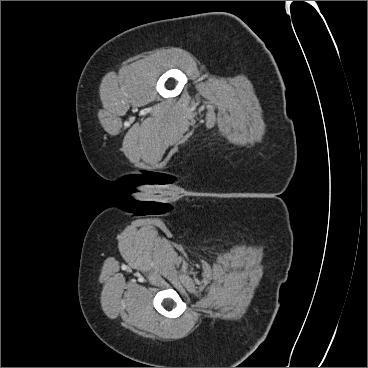

In [28]:
data["train"][0]["image"]

In [29]:
data["train"][0]["label"]

0

## Fine-tune the model

Contrastive image-text learning is a method that trains models to learn the relationship between images and text, such that the representations of matching image-text pairs are brought closer together in a shared embedding space while non-matching pairs are pushed further apart.

This notebook demonstrates contrastive fine-tuning of MedSigLIP, where the vision and text encoders are jointly trained on image and text data, using the `Trainer` from the Hugging Face `Transformers` library.

Define a data collator to prepare batches of training examples.

In [30]:
import torch


def collate_fn(examples):
    # Extract images and labels
    images = [example["image"] for example in examples]
    labels = [example["label"] for example in examples]
    
    # Process images
    batch = processor(images=images, return_tensors="pt")
    
    # Add labels
    batch["labels"] = torch.tensor(labels)
    
    return batch

Configure training parameters in [`TrainingArguments`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments).

In [40]:
from transformers import TrainingArguments

num_train_epochs = 2  # @param {type: "number"}
learning_rate = 1e-5  # @param {type: "number"}

training_args = TrainingArguments(
    output_dir="medsiglip-abdominal-pain",  # Directory and Hub repository id to save the model to
    num_train_epochs=num_train_epochs,      # Number of training epochs
    per_device_train_batch_size=16,          # Batch size per device during training
    per_device_eval_batch_size=16,           # Batch size per device during evaluation
    gradient_accumulation_steps=8,          # Number of steps before performing a backward/update pass
    logging_steps=10,                       # Number of steps between logs
    save_strategy="epoch",                  # Save checkpoint every epoch
    eval_strategy="steps",                  # Evaluate every `eval_steps`
    eval_steps=50,                          # Number of steps between evaluations
    learning_rate=learning_rate,            # Learning rate
    weight_decay=0.01,                      # Weight decay to apply
    warmup_steps=5,                         # Number of steps for linear warmup from 0 to learning rate
    lr_scheduler_type="cosine", 
    remove_unused_columns=False,            # Use cosine learning rate scheduler
    push_to_hub=True,                       # Push model to Hub
    report_to="tensorboard",                # Report metrics to tensorboard
)

In [41]:
import evaluate
import numpy as np

# Load the metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Convert logits to predicted class indices
    predictions = np.argmax(predictions, axis=1)
    
    # Compute metrics
    metrics = {}
    metrics.update(accuracy_metric.compute(
        predictions=predictions,
        references=labels,
    ))
    metrics.update(f1_metric.compute(
        predictions=predictions,
        references=labels,
        average="weighted",
    ))
    return metrics


Construct a [`Trainer`](https://huggingface.co/docs/transformers/trainer) using the previously defined training parameters and data collator.

In [42]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data["train"],
    eval_dataset=data["validation"].shuffle().select(range(200)),  # Use subset of validation set for faster run
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

Launch the fine-tuning process.

**Note:** This may take around 3 hours to run using the default configuration.

In [45]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
50,1.896900,1.008653,0.670000,0.672929
100,0.265400,1.101701,0.685000,0.693589
150,0.020000,1.502883,0.670000,0.680319
200,0.006800,1.606511,0.665000,0.676759


TrainOutput(global_step=230, training_loss=1.203884819344334, metrics={'train_runtime': 2568.6379, 'train_samples_per_second': 11.406, 'train_steps_per_second': 0.09, 'total_flos': 0.0, 'train_loss': 1.203884819344334, 'epoch': 2.0})

Save the final model to Hugging Face Hub.

## Evaluate the fine-tuned model on a classification task

Test dataset size: 6688
Evaluating model on test dataset...


Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [03:38<00:00,  1.04s/it]

EVALUATION RESULTS
Overall Accuracy: 0.7220
Weighted F1-Score: 0.7284
Macro F1-Score: 0.5946

Per-Class Metrics:
----------------------------------------------------------------------
Class           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
normal          0.9031       0.7761       0.8348       3903      
appendicitis    0.4055       0.4018       0.4037       550       
cholezystitis   0.7150       0.7351       0.7249       604       
perforation     0.5554       0.8107       0.6592       1236      
sigmoid         0.3654       0.3367       0.3505       395       
----------------------------------------------------------------------
Weighted Avg    0.7492       0.7220       0.7284       6688      
Macro Avg       0.5889       0.6121       0.5946       6688      

Detailed Classification Report:
               precision    recall  f1-score   support

       normal     0.9031    0.7761    0.8348      3903
 a

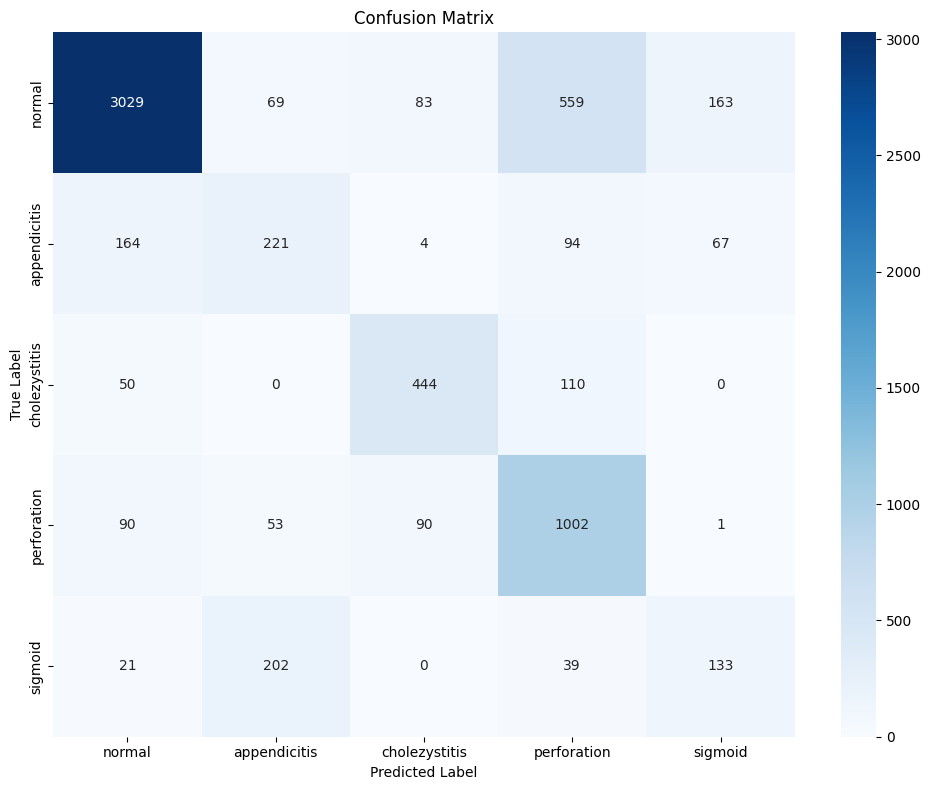

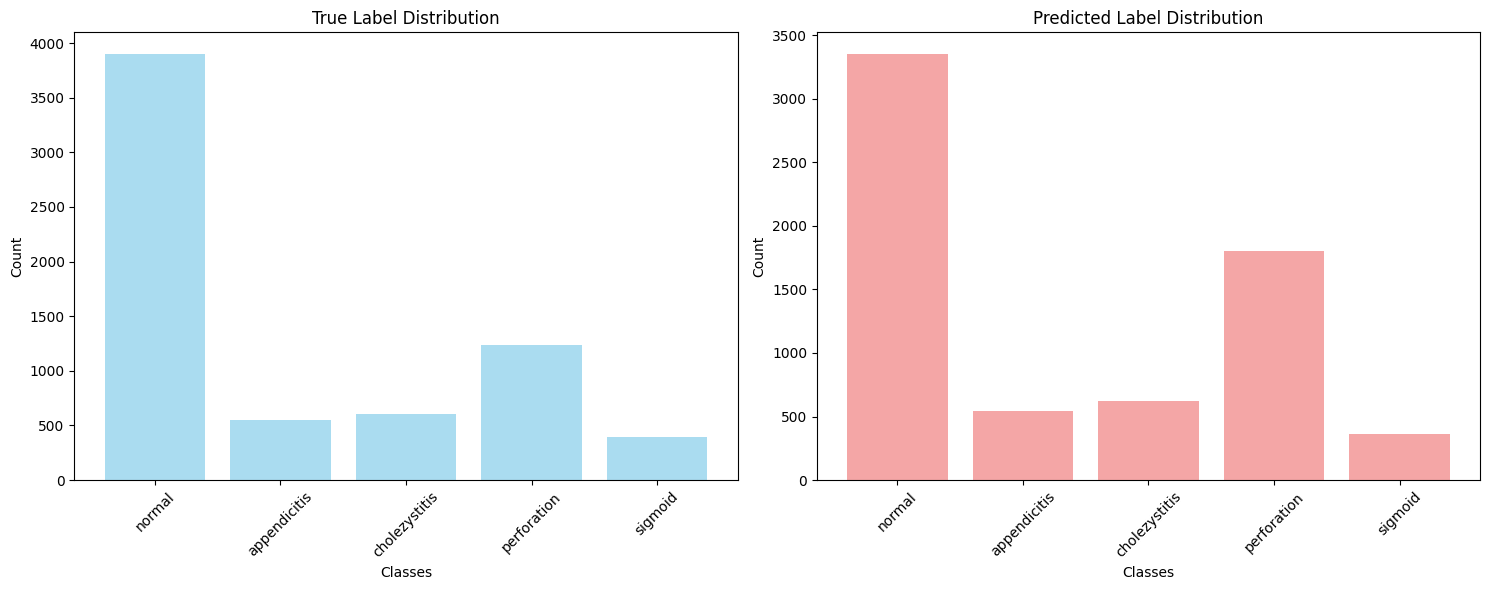

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    classification_report, 
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def evaluate_model(model, test_dataset, processor, batch_size=32, device='cuda'):
    """
    Comprehensive evaluation of the fine-tuned model on test data
    """
    
    # Set model to evaluation mode
    model.eval()
    
    # Create test dataloader
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=collate_fn
    )
    
    all_predictions = []
    all_labels = []
    all_logits = []
    
    print("Evaluating model on test dataset...")
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # Move batch to device
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(pixel_values=pixel_values)
            
            # Handle different output formats
            if isinstance(outputs, dict):
                logits = outputs['logits']
            else:
                logits = outputs.logits
            
            # Get predictions
            predictions = torch.argmax(logits, dim=-1)
            
            # Store results
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_logits.extend(logits.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels), np.array(all_logits)

def compute_detailed_metrics(predictions, labels, class_names):
    """
    Compute detailed evaluation metrics
    """
    
    # Basic metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, predictions, average=None
    )
    
    # Weighted averages
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    
    # Macro averages
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, predictions, average='macro'
    )
    
    print("="*50)
    print("EVALUATION RESULTS")
    print("="*50)
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Weighted F1-Score: {f1_weighted:.4f}")
    print(f"Macro F1-Score: {f1_macro:.4f}")
    print()
    
    # Per-class metrics
    print("Per-Class Metrics:")
    print("-" * 70)
    print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("-" * 70)
    
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<15} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")
    
    print("-" * 70)
    print(f"{'Weighted Avg':<15} {precision_weighted:<12.4f} {recall_weighted:<12.4f} {f1_weighted:<12.4f} {sum(support):<10}")
    print(f"{'Macro Avg':<15} {precision_macro:<12.4f} {recall_macro:<12.4f} {f1_macro:<12.4f} {sum(support):<10}")
    
    return {
        'accuracy': accuracy,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'per_class_precision': precision,
        'per_class_recall': recall,
        'per_class_f1': f1,
        'support': support
    }

def plot_confusion_matrix(labels, predictions, class_names):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(labels, predictions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    return cm

def plot_class_distribution(labels, predictions, class_names):
    """
    Plot class distribution comparison
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # True labels distribution
    unique_true, counts_true = np.unique(labels, return_counts=True)
    ax1.bar([class_names[i] for i in unique_true], counts_true, color='skyblue', alpha=0.7)
    ax1.set_title('True Label Distribution')
    ax1.set_xlabel('Classes')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)
    
    # Predicted labels distribution
    unique_pred, counts_pred = np.unique(predictions, return_counts=True)
    ax2.bar([class_names[i] for i in unique_pred], counts_pred, color='lightcoral', alpha=0.7)
    ax2.set_title('Predicted Label Distribution')
    ax2.set_xlabel('Classes')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Main evaluation script
def run_evaluation():
    """
    Main function to run complete evaluation
    """
    
    # Class names
    ABDOMINAL_PAIN_CLASSES = ['normal', 'appendicitis', 'cholezystitis', 'perforation', 'sigmoid']
    
    # Get test data
    test_data = data["test"]
    
    print(f"Test dataset size: {len(test_data)}")
    
    # Run evaluation
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    predictions, labels, logits = evaluate_model(
        model, 
        test_data, 
        processor, 
        batch_size=32, 
        device=device
    )
    
    # Compute metrics
    metrics = compute_detailed_metrics(predictions, labels, ABDOMINAL_PAIN_CLASSES)
    
    # Generate classification report
    print("\nDetailed Classification Report:")
    print("="*50)
    print(classification_report(
        labels, 
        predictions, 
        target_names=ABDOMINAL_PAIN_CLASSES,
        digits=4
    ))
    
    # Plot visualizations
    print("\nGenerating visualizations...")
    cm = plot_confusion_matrix(labels, predictions, ABDOMINAL_PAIN_CLASSES)
    plot_class_distribution(labels, predictions, ABDOMINAL_PAIN_CLASSES)
    
    return metrics, predictions, labels, logits

# Run the evaluation
evaluation_results = run_evaluation()


In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    classification_report, 
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import os

def evaluate_model(model, test_dataset, processor, image_paths, batch_size=32, device='cuda'):
    """
    Comprehensive evaluation of the fine-tuned model on test data, using image_paths for test data
    """
    
    # Set model to evaluation mode
    model.eval()
    
    # Create test dataloader
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=collate_fn
    )
    
    all_predictions = []
    all_labels = []
    all_logits = []
    all_image_paths = []
    
    print("Evaluating model on test dataset...")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_loader, desc="Testing")):
            # Move batch to device
            if 'pixel_values' not in batch or 'labels' not in batch:
                raise ValueError("Batch missing required keys: 'pixel_values' or 'labels'.")
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(pixel_values=pixel_values)
            logits = outputs['logits']  # Simplified: model always returns dict
            
            # Get predictions
            predictions = torch.argmax(logits, dim=-1)
            
            # Get image paths for the current batch
            batch_size = len(batch['labels'])
            start_idx = batch_idx * batch_size
            batch_image_paths = image_paths['test'][start_idx:start_idx + batch_size]
            if len(batch_image_paths) != batch_size:
                raise ValueError(f"Mismatch between batch size ({batch_size}) and image paths ({len(batch_image_paths)}) at batch {batch_idx}")
            
            # Store results
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_logits.extend(logits.cpu().numpy())
            all_image_paths.extend(batch_image_paths)
    
    return np.array(all_predictions), np.array(all_labels), np.array(all_logits), all_image_paths

def compute_detailed_metrics(predictions, labels, class_names):
    """
    Compute detailed evaluation metrics
    """
    
    # Basic metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, predictions, average=None
    )
    
    # Weighted averages
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    
    # Macro averages
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, predictions, average='macro'
    )
    
    print("="*50)
    print("EVALUATION RESULTS")
    print("="*50)
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Weighted F1-Score: {f1_weighted:.4f}")
    print(f"Macro F1-Score: {f1_macro:.4f}")
    print()
    
    # Per-class metrics
    print("Per-Class Metrics:")
    print("-" * 70)
    print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("-" * 70)
    
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<15} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")
    
    print("-" * 70)
    print(f"{'Weighted Avg':<15} {precision_weighted:<12.4f} {recall_weighted:<12.4f} {f1_weighted:<12.4f} {sum(support):<10}")
    print(f"{'Macro Avg':<15} {precision_macro:<12.4f} {recall_macro:<12.4f} {f1_macro:<12.4f} {sum(support):<10}")
    
    return {
        'accuracy': accuracy,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'per_class_precision': precision,
        'per_class_recall': recall,
        'per_class_f1': f1,
        'support': support
    }

def plot_confusion_matrix(labels, predictions, class_names):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(labels, predictions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    return cm

def plot_class_distribution(labels, predictions, class_names):
    """
    Plot class distribution comparison
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # True labels distribution
    unique_true, counts_true = np.unique(labels, return_counts=True)
    ax1.bar([class_names[i] for i in unique_true], counts_true, color='skyblue', alpha=0.7)
    ax1.set_title('True Label Distribution')
    ax1.set_xlabel('Classes')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)
    
    # Predicted labels distribution
    unique_pred, counts_pred = np.unique(predictions, return_counts=True)
    ax2.bar([class_names[i] for i in unique_pred], counts_pred, color='lightcoral', alpha=0.7)
    ax2.set_title('Predicted Label Distribution')
    ax2.set_xlabel('Classes')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def run_evaluation(image_paths):
    """
    Main function to run complete evaluation and save results to Excel with image paths
    """
    
    # Class names
    ABDOMINAL_PAIN_CLASSES = ['normal', 'appendicitis', 'cholezystitis', 'perforation', 'sigmoid']
    
    # Get test data
    test_data = data["test"]
    
    print(f"Test dataset size: {len(test_data)}")
    
    # Validate image_paths
    if 'test' not in image_paths:
        raise ValueError("image_paths must contain 'test' split")
    if len(image_paths['test']) != len(test_data):
        raise ValueError(f"Mismatch between test dataset size ({len(test_data)}) and image_paths['test'] size ({len(image_paths['test'])})")
    
    # Run evaluation
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    predictions, labels, logits, test_image_paths = evaluate_model(
        model, 
        test_data, 
        processor, 
        image_paths,
        batch_size=32, 
        device=device
    )
    
    # Compute metrics
    metrics = compute_detailed_metrics(predictions, labels, ABDOMINAL_PAIN_CLASSES)
    
    # Generate classification report
    print("\nDetailed Classification Report:")
    print("="*50)
    print(classification_report(
        labels, 
        predictions, 
        target_names=ABDOMINAL_PAIN_CLASSES,
        digits=4
    ))
    
    # Plot visualizations
    print("\nGenerating visualizations...")
    cm = plot_confusion_matrix(labels, predictions, ABDOMINAL_PAIN_CLASSES)
    plot_class_distribution(labels, predictions, ABDOMINAL_PAIN_CLASSES)
    
    # Save results to Excel
    output_file = "evaluation_results.xlsx"
    print(f"\nSaving results to {output_file}...")
    
    # Map indices to class names
    predicted_classes = [ABDOMINAL_PAIN_CLASSES[pred] for pred in predictions]
    true_classes = [ABDOMINAL_PAIN_CLASSES[label] for label in labels]
    
    # Create DataFrame
    results_df = pd.DataFrame({
        'Image_Path': test_image_paths,
        'Predicted_Label': predicted_classes,
        'True_Label': true_classes,
        'Prediction_Index': predictions,
        'True_Label_Index': labels
    })
    
    # Add class names as metadata (e.g., in a separate row)
    class_names_row = pd.DataFrame({
        'Image_Path': ['Class_Names'],
        'Predicted_Label': [', '.join(ABDOMINAL_PAIN_CLASSES)],
        'True_Label': [''],
        'Prediction_Index': [''],
        'True_Label_Index': ['']
    })
    
    # Concatenate results and class names
    final_df = pd.concat([results_df, class_names_row], ignore_index=True)
    
    # Save to Excel
    try:
        final_df.to_excel(output_file, index=False, engine='openpyxl')
        print(f"✅ Results saved successfully to {output_file}")
    except Exception as e:
        print(f"❌ Failed to save results to Excel: {str(e)}")
    
    return metrics, predictions, labels, logits

# Assuming image_paths and data_splits are defined
data_splits = ['train', 'validation', 'test']  # Example splits
image_paths = {
    split: [f["path"] for f in data[split].data_files]
    for split in data_splits
}

# Run the evaluation
evaluation_results = run_evaluation(image_paths)